![Sizing Lab](./assets/images/Baniere.png)
![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/Baniere.png)

# Case study specification

*Written by Marc Budinger, INSA Toulouse, France*

We will now develop tools allowing:
- generate mission profiles corresponding to a new need for an urban transport line
- optimize certain mission profiles choices to minimize consumption

In order to have flexibility in the definition of the case studies, an object-oriented programming approach will be used.

### Electric vehicles

Different types of urban electric vehicles exist (tram, trolley bus, electric bus), we can define a general vehicle class wich can represent the multiple possible supports.

In [18]:
class vehicle:
    def __init__(self, MaxSpeed, MaxAcc,NumberPass,Weight,Crr,Cd,FrontArea):
        self.MaxSpeed = MaxSpeed # [m/s] maximal speed
        self.MaxAcc = MaxAcc # [m/s²] maximal acceleration
        self.NumberPass = NumberPass # [-] passenger capacity (3p/m²)
        self.Weight = Weight # [kg] effective weight (with passenger 62kg/p)
        self.Crr = Crr # [-] rolling resistance coefficient
        self.Cd = Cd # [-] drag coefficient
        self.FrontArea = FrontArea # [m²] frontal area
        self.Fmax = Weight*MaxAcc # [N] max traction force
        self.Pmax = self.Fmax*self.MaxSpeed # [W] max corner power


Here you will find some useful vehicle characteristics for the rest of the study.

| Attribute  | Tram      | Trolleybus      | Bus | Car (Tesla 3) |
|---    |:-:    |:-:    |:-:    |:-:    |
| Maximum operational speed     |  60 km/h     |  60 km/h     | 50 km/h | 100 km/h (1st gear) |
| Acceleration and braking      | 1.2 m/s²      |  1.2 m/s²     | 1.2 m/s² | 4.6 m/s² |
| Passenger capacity @ 3p/m²      | 220      | 138      | 95 | 4 |
| Vehicle effective weight @ 62 kg/p | 57049 kg | 27656 kg | 19500 kg |1800 kg  |
| Rolling resistance coefficient | 0.006 | 0.015 | 0.15 | 0.015 |
| Aerodynamic drag coefficient| 0.6 | 0.6 |0.6 | 0.23 | 
| Frontal area | 8.5 m² | 8.5 m² | 8.5 m²| 2.22 m² |



> **Exercice:** Define 4 instances of the  class `vehicle` corresponding to the vehicles above.

In [19]:
Tram = vehicle(60*1e3/3600,1.2,220,57049,0.006,0.6,8.5)
TrolleyBus = vehicle(60*1e3/3600,1.2,138,27656,0.015,0.6,8.5)
Bus = vehicle(50*1e3/3600,1.2,95,19500,0.015,0.6,8.5)
Car = vehicle(60*1e3/3600,4.6,4,1800,0.015,0.23,2.22)

### Generation and mission profile simulation

The objective now is to simulate the dynamic evolution of the main mechanical quantities (position, speed, acceleration, tractive effort, driving power) on typical sections of urban routes.

When a vehicle travels from point A (Starting point) to point B (Stopping point ) it generally passes through four stages namely:
- Accelerating mode
- Constant speed mode
- Coasting mode
- Braking mode

The control points for switching from one mode to another are defined in the following code using 3 parameters $k_1, k_2, k_3$ as shown in the figure below. 
![General Speed Profile](./assets/images/GeneralspeedProfile.png)
![General Speed Profile](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/GeneralspeedProfile.png)

A extrema case is a triangular profile without constant speed and coasting modes which minimizes acceleration and inertial driving force.
> **Question:** Give the relationship between acceleration, average speed and distance traveled if we assume the acceleration and braking phases are perfectly linear.

> **Questions:** Is this type of profile the one that minimizes the energy consumed ? What rules do you recommend to minimize the energy consumed?

The following code implements a control logic comprising the 4 phases defined previously and a numerical integration of the differential equation corresponding to the longitudinal dynamics of the vehicle.

> **Question:** what evolution should be added to take into account variations in altitude?

In [20]:
import numpy as np
from scipy import signal
from scipy.optimize import fmin_slsqp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class SimulSection:
    def __init__(self,Vehicle,Distance, MeanSpeed,BrakeRatioMax,dt):
        # Parameters definition
        self.Vehicle = Vehicle # vehicle parameters
        self.Distance = Distance # [m] distance to travel
        self.MeanSpeed = MeanSpeed # [m/s] Mean Speed < MaxSpeep
        self.TravelTime = self.Distance / self.MeanSpeed  # [s] Travel time
        self.BrakeRatioMax = BrakeRatioMax # [-], inferieur à 1, ratio de puissance de freinage / Puisssance d'acceleration
        self.rho = 1.25 # [kg/m3] air density
        self.g = 9.81 # [m/s²] gravity
        self.dt = dt # Pas de temps de simulation
        
        # Tests sur les lois de mouvement
        # https://fr.wikipedia.org/wiki/Loi_de_mouvement
        
        if (MeanSpeed>=Vehicle.MaxSpeed):
           print("Mean Speed is to high : Mean Speed > Vehicle Max Speed") 
        
        # profil triangulaire : minimise l'acceleration
        #     amax = 4⋅xf/T2 ;    vmax = 2⋅xf/T ; amax = vmax / (T/2) ; vmean = vmax / 2
        #     amax = 4*vmean^2 / xf
        
        # Calcul de l'acceleration possible a pleine vitesse
        AmaxFullSpeed=(self.Vehicle.Fmax - 1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*self.Vehicle.MaxSpeed**2 - self.Vehicle.Weight*self.g*self.Vehicle.Crr)/self.Vehicle.Weight
        if (AmaxFullSpeed < 4*self.MeanSpeed / self.TravelTime):
            print("Vehicle Max Acceleration (depending of max force) is too low or travel distance too small or mean speed too small")
            
            
    # dynamic model for acceleration, coasting and braking
    def model(self, y,F):
        # state
        x, dxdt = y
        # System: acceleration calculation
        dxdt2 = (F-self.Vehicle.Crr*self.Vehicle.Weight*self.g*np.sign(dxdt)
                 -1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*dxdt**2**np.sign(dxdt))/self.Vehicle.Weight
        dydt = [dxdt, dxdt2]
        return dydt 

  
    # https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html
    # solver numerique
        
    def solver(self, x):
        k1, k2, k3 = x
        dt=self.dt # [s] pas de temps pour l'integration
        t=0
        self.tsection = [0]
        self.xsection = [0]
        self.vsection = [0]
        self.asection = [0] 
        self.psection = [0]
        self.Fsection = [0]
        self.NRJsection = [0]
        NRJ=0
        
        y0 = np.array([0, 0]) 
        y= y0
        
      
        while (y[1]>=0):
            # Traction/Braking force
            if (y[0]<k1*k2*k3*self.Distance):
                F=self.Vehicle.Fmax
                dydt = self.model(y, F)
            elif (y[0]<k3*k2*self.Distance):
                F=self.Vehicle.Crr*self.Vehicle.Weight*self.g+1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*y[1]**2
                dydt = [y[1], 0]
            elif (y[0]<k3*self.Distance):
                F=0
                dydt = self.model(y, F)
            else:
                F=-self.Vehicle.Fmax
                dydt = self.model(y, F)
                
            self.Fsection = self.Fsection + [F]    
                
            # Euler integration de la postion y[0] et de la vitesse y[1]
            y = y + dt * np.array(dydt)

            t = t + dt
            NRJ = NRJ+y[1]*F*dt

           
            self.tsection = self.tsection + [t]
            self.xsection = self.xsection + [y[0]]
            self.vsection = self.vsection + [y[1]]
            self.psection = self.psection + [y[1]*F]
            self.asection = self.asection + [dydt[1]] 
            self.NRJsection = self.NRJsection + [NRJ]
            
    
    def plot(self):
        fig, axs = plt.subplots(3,2)
        axs[0,0].plot(self.tsection,self.xsection,'b-',label='Simulation')
        axs[0,0].plot(self.tsection,self.Distance*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[0,0].set_ylabel("Position (m)")
        axs[0,0].legend()
        axs[0,0].grid()
        axs[1,0].plot(self.tsection,self.vsection,'b-', label='Simulation')
        axs[1,0].plot(self.tsection,self.MeanSpeed*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[1,0].plot(self.tsection,np.mean(self.vsection)*np.ones(len(self.tsection)),'r--',label='Mean')
        axs[1,0].set_ylabel("Speed (m/s)")
        #axs[1].sharex(axs[0])
        axs[1,0].grid()    
        axs[1,0].set_xlabel('Time (s)')    
        axs[0,1].plot(self.tsection,self.Fsection,'b-')
        axs[0,1].set_ylabel("Force (N)")
        axs[0,1].grid()
        
        axs[2,0].plot(self.tsection,self.asection,'b-')
        axs[2,0].set_ylabel("Acceleration (m/s²)")
        axs[2,0].grid()
        axs[2,0].set_xlabel('Time (s)')    
        
        axs[1,1].plot(self.tsection,np.array(self.psection)*1e-3,'b-')
        axs[1,1].set_ylabel("Power (kW)")
        axs[1,1].grid()
        axs[1,1].set_xlabel('Time (s)')   
        
        axs[2,1].plot(self.tsection,np.array(self.NRJsection)*1e-3,'b-')
        axs[2,1].set_ylabel("Energy (kJ)")
        axs[2,1].grid()
        axs[2,1].set_xlabel('Time (s)') 
        fig.tight_layout()

    def ConsumptionPerPax(self,x):
        Trajet.solver(x)
        print("Consumption per passenger: %.2f J/(Pax.km)"%(Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance))
        return (Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance)
    


Consumption per passenger: 22.19 J/(Pax.km)


22.190205194930893

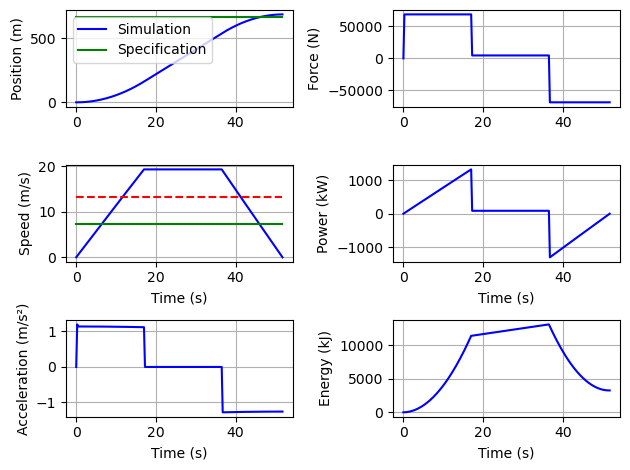

In [21]:
Trajet = SimulSection(Tram, 670, 26*1e3/3600,1,0.25)
X=[0.3,1,0.8]
Trajet.solver(X)
Trajet.plot()
Trajet.ConsumptionPerPax(X)

### Optimizing power consumption using speed profile

The following article shows that it is possible to optimize the consumption of a tram:
> Tian, Z., Zhao, N., Hillmansen, S., Roberts, C., Dowens, T., & Kerr, C. (2019). SmartDrive: Traction energy optimization and applications in rail systems. IEEE Transactions on Intelligent Transportation Systems, 20(7), 2764-2773.

The previous class is now extended to allow optimization of variables $k_1, k_2, k_3$.



In [22]:
class OptimSection(SimulSection):   
    # Gradient optimization
    def objectif(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        return (self.NRJsection[-1]/NRJmin)
                
    def contraintes(self, x):
        self.solver(x)
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        print(PowerAccBrakeRatio)
        # contraintes en distance, vitesse moyenne (ou duree de trajet, vitesse au freinage), ratio puissance freinage / acc 
        return [(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, self.BrakeRatioMax-PowerAccBrakeRatio ]    
      
    
    def optimize(self,x0):
        
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,.99)]
        
        Xopt=fmin_slsqp(func=self.objectif, x0=x0, f_ieqcons = self.contraintes, bounds=Xbound, epsilon=1e-2)
                
        return Xopt
    
    # Differential evolution optimization
    
    def objectifG(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        pen=0
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        VecC=[(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, self.BrakeRatioMax-PowerAccBrakeRatio ]      
        for C in VecC:
            if (C<0):
                pen=pen-1e2*C
        
        return (self.NRJsection[-1]/NRJmin+pen)
    
    
    
    def optimizeG(self,x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,0.99)]
        res=differential_evolution(func=self.objectifG, x0=x0, bounds=Xbound)
        print(res)
        return res.x
    


     fun: 1.1158969465170516
 message: 'Optimization terminated successfully.'
    nfev: 1309
     nit: 28
 success: True
       x: array([0.14569029, 0.35729007, 0.98873406])
Vecteur optimal : [0.14569029 0.35729007 0.98873406]
0.5722045302065372
Vecteur contrainte : [0.00994567209685108, 0.00020729684908794098, 0.027795469793462813]
Consumption per passenger: 17.20 J/(Pax.km)


17.201555252553543

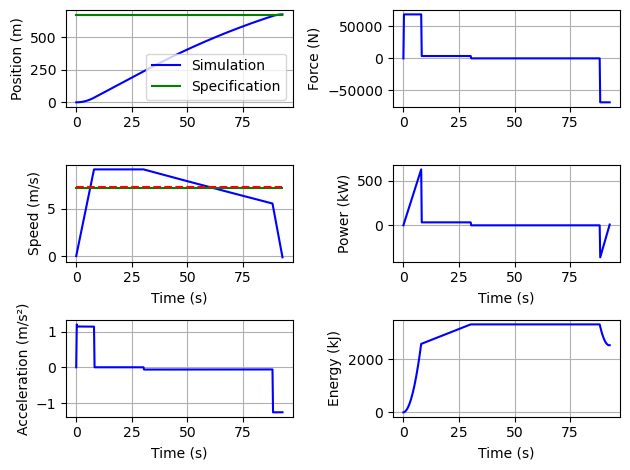

In [23]:
Trajet = OptimSection(Tram, 670, 26*1e3/3600,0.6,0.25)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
print("Vecteur optimal :",Xopt)
print("Vecteur contrainte :", Trajet.contraintes(Xopt))

Trajet.plot()
Trajet.ConsumptionPerPax(Xopt)

> **Question:** Compare this optimized profile to a profile with only 3 segments: maximum acceleration, constant speed, maximum deceleration. To do this, calculate the corresponding factors $k_1,k_2, k_3$.

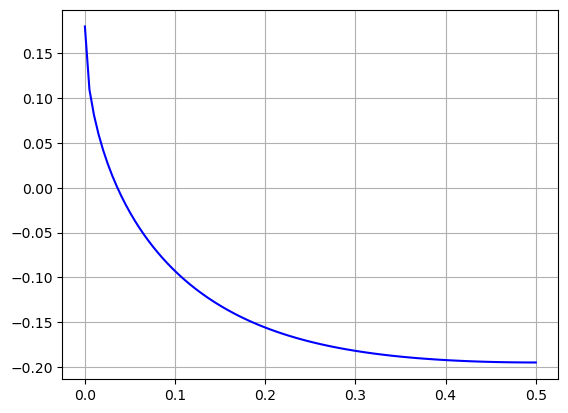

In [24]:
# Parameters calculation
# on pose x = sqrt(k1)
from scipy.optimize import root

a = Trajet.MeanSpeed/(2*Trajet.Vehicle.MaxAcc*Trajet.Distance)**0.5

f = lambda x: a+(x*(1-x))**1.5-(x*(1-x))**0.5

X=np.linspace(0,0.5,100)

plt.plot(X,f(X),'b-')
plt.grid()
plt.show()

sol=root(f, 0.1)

k1=float(sol.x)


[0.036125972011676784, 1, 0.9638740279883232]
Consumption per passenger: 17.01 J/(Pax.km)


17.009841585775153

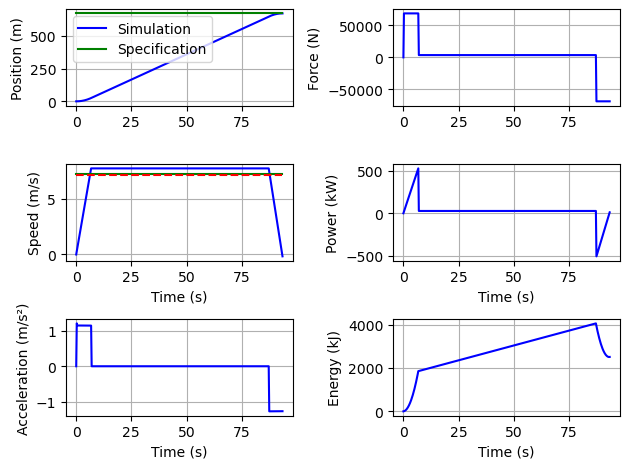

In [25]:
k3=1-k1

X=[k1,1,k3]
print(X)
Trajet.solver(X)
Trajet.plot()
Trajet.ConsumptionPerPax(X)


### Comparaison de différents moyens de transport



In [26]:
print("Tramway :")
Trajet = OptimSection(Tram, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Trolleybus :")
Trajet = OptimSection(TrolleyBus, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Bus :")
Trajet = OptimSection(Bus, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)
print("----")

print("Car :")
Trajet = OptimSection(Car, 670, 26*1e3/3600,0.5,1)
X=[0.036125972011676784, 1, 0.9638740279883232]
Xopt=Trajet.optimizeG(X)
Trajet.ConsumptionPerPax(Xopt)

Tramway :
     fun: 1.2943682600385298
 message: 'Optimization terminated successfully.'
    nfev: 1264
     nit: 27
 success: True
       x: array([0.10144121, 0.38725504, 0.98816652])
Consumption per passenger: 20.18 J/(Pax.km)
----
Trolleybus :
     fun: 1.1542825768183642
 message: 'Optimization terminated successfully.'
    nfev: 1174
     nit: 25
 success: True
       x: array([0.12665709, 0.50208392, 0.98705863])
Consumption per passenger: 34.09 J/(Pax.km)
----
Bus :
     fun: 1.1554437831959297
 message: 'Optimization terminated successfully.'
    nfev: 1444
     nit: 31
 success: True
       x: array([0.05188377, 0.76235525, 0.9873178 ])
Consumption per passenger: 35.30 J/(Pax.km)
----
Car :
     fun: 1.522255018926166
 message: 'Optimization terminated successfully.'
    nfev: 1894
     nit: 41
 success: True
       x: array([0.00483721, 0.99075725, 0.98892493])
Consumption per passenger: 102.08 J/(Pax.km)


102.08184402614765

### Simulation d'une ligne complète

Proposer une évolution de ces codes informatiques pour pouvoir :
- simuler le profil de puissance nécessaire à la motorisation sur une ligne complete comportant plusieurs troncons.
- fournir les informations nécessaires au dimensionnement des pack batterie/supercapacité qui pourrait etre adjoint. On suppose ici un rendement de la chaine de motorisation de 100%.
- prendre en compte l'energie qui pourrait provenir des catenaires ou des stations de recharge. Pour minimiser le dimensionnement de ces dernières et standardiser leur conception, que chaque station de recharge fournira la meme puissance permettant de compenser l'energie moyenne du trajet complet (seule la duree de charge varira). 

Dans un 1er temps 

line =
    Descripteur de ligne(vecteur distance section, vecteur vitesse moyenne, chargeurs, catenaire)
    Sections
    Calcul de 
    Chargeur(puissance, temps)
    Catenaire(puissance)
    


In [27]:
from scipy import signal

class line():
    def __init__(self,Vehicle, Distances,Speeds, Chargers, StopDuration, RatioBrakeMax):
        i=0
        self.Section=[]
        self.Chargers =  Chargers
        self.StopDuration = StopDuration
        self.RatioBrakeMax = RatioBrakeMax
        self.PowerStorage= []
        self.GlobalTime=[]
        self.GlobalNRJStorage=[]
        self.PowerLF = []
        self.PowerHF = []
        self.LFNRJStorage=[]
        self.HFNRJStorage=[]
        self.TotalNRJAging=[]
        self.LFNRJAging=[]
        self.TotalLineDistance =  sum(Distances)
        self.dt=0.25 # Pas de temps pour integration
        
        for d,s,c in zip(Distances,Speeds,Chargers):
            print("Section %.i: %.i m at %.2f m/s %s charger"%(i+1,d,s, "whith" if c else "without"))
            self.Section=self.Section+[OptimSection(Vehicle,d,s,self.RatioBrakeMax,self.dt)]
            i=i+1
    
    def optimLine(self):
        X=[0.1,1,0.9]
        for i in range(len(self.Section)):
            self.Section[i].optimizeG(X)
            self.Section[i].plot()   
    
    # on calcule ici la puissance a fournir par l'element de stockage  
    def CalculPowerStorage(self):
        NRJ = 0
        self.PowerStorage= []
        self.GlobalTime= []
        dt=self.dt # [s] pas de temps pour l'integration
        
        # on construit le vecteur puissance
        for i in range(len(self.Section)):
            print(i)
            NRJ=NRJ+self.Section[i].NRJsection[-1] # on ajoute l'energie consommee sur le troncon
            self.PowerStorage = self.PowerStorage + self.Section[i].psection
            if (self.Chargers[i] == True and i<(len(self.Section)-1)):
                tcharge=NRJ/self.Section[i].Vehicle.Pmax
            else:
                tcharge=0
            if (tcharge>=self.StopDuration):
                self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                NRJ=0
            else:
                if (i<(len(self.Section)-1)):
                    self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                    self.PowerStorage = self.PowerStorage + [0]*int((self.StopDuration-tcharge)/dt)
                if (self.Chargers[i] == True) :
                    NRJ=0  
        
        # Vecteur temps
        t=0
        for i in range(len(self.PowerStorage)):
            self.GlobalTime = self.GlobalTime + [t]
            t = t + dt
            
    # on calcule ici la puissance en BF et HF
    def FilterPower(self, omega):
        TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])
        time, self.PowerLF, state = signal.lsim(TF, self.PowerStorage , self.GlobalTime)
        self.PowerHF = self.PowerStorage -  self.PowerLF
        
    # on construit les vecteurs NRJ
    def IntegrateNRJ(self):
        t=0
        NRJtotal=0
        NRJHF=0
        NRJLF=0
        NRJTotalAging=0
        NRJLFAging=0
        self.HFNRJStorage = []
        self.GlobalNRJStorage = []
        self.LFNRJStorage = []
        self.TotalNRJAging=[]
        self.LFNRJAging=[]
        dt=self.dt
        
        for i in range(len(self.PowerStorage)):
            self.GlobalNRJStorage = self.GlobalNRJStorage + [NRJtotal]
            self.HFNRJStorage = self.HFNRJStorage + [NRJHF]
            self.LFNRJStorage = self.LFNRJStorage + [NRJLF]
            self.TotalNRJAging = self.TotalNRJAging + [NRJTotalAging]
            self.LFNRJAging = self.LFNRJAging + [NRJLFAging]
        
            t = t + dt
            NRJtotal = NRJtotal+(self.PowerStorage[i])*dt
            NRJHF = NRJHF+(self.PowerHF[i])*dt
            NRJLF = NRJLF+(self.PowerLF[i])*dt
        
            NRJTotalAging = NRJTotalAging + abs(self.PowerStorage[i])*dt
            NRJLFAging = NRJLFAging + abs(self.PowerLF[i])*dt
        PmaxHF = max(self.PowerHF)/1e3 # kW
        PmaxLF = max(self.PowerLF)/1e3 # kW 
        PmaxBrakeLF = abs(min(self.PowerLF))/1e3 # kW, Max power braking
        NRJHF = (max(self.HFNRJStorage) - min(self.HFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLF = (max(self.LFNRJStorage) - min(self.LFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLFaging = (max(self.LFNRJAging) - min(self.LFNRJAging))/3600/1e3/self.TotalLineDistance*1e3 # NRJ en kWh/km 
        
        return PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF, NRJLFaging
          
    
    
                
    # on calcule ici 
    def plot(self):
        fig, axs = plt.subplots(3,1)
        axs[0].plot(self.GlobalTime,self.PowerStorage,'b-',label='Total')
        axs[0].plot(self.GlobalTime,self.PowerLF,'r-.',label='LF')
        axs[0].plot(self.GlobalTime,self.PowerHF,'g-.',label='HF')
        axs[0].set_ylabel("Power (W)")
        axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[0].grid()
        axs[1].plot(self.GlobalTime,self.GlobalNRJStorage,'b-',label='Total')
        axs[1].plot(self.GlobalTime,self.LFNRJStorage,'r-.',label='LF')
        axs[1].plot(self.GlobalTime,self.HFNRJStorage,'g-.',label='HF')
        axs[1].set_ylabel("Energy (J)")
        axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[1].grid()
        axs[2].plot(self.GlobalTime,self.TotalNRJAging,'b-',label='Total')
        axs[2].plot(self.GlobalTime,self.LFNRJAging,'r-.',label='LF')
        axs[2].set_ylabel("Equivalent Aging Energy (J)")
        axs[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[2].grid()
        
        axs[2].set_xlabel('Time (s)') 
        
        fig.tight_layout()
       
            
     
            
        
        
            

In [51]:
ToulouseC=line(Bus,[700,500,400,700,300,300,300,300,300],[7, 7, 7,5,5,5,5,5],[False,False,False,False,False,False,False,True], 20, 0.6)
#ToulouseC=line(Bus,[700,500,400],[7, 7, 7],[False,False,True], 20, 0.6)


Section 1: 700 m at 7.00 m/s without charger
Section 2: 500 m at 7.00 m/s without charger
Section 3: 400 m at 7.00 m/s without charger
Section 4: 700 m at 5.00 m/s without charger
Section 5: 300 m at 5.00 m/s without charger
Section 6: 300 m at 5.00 m/s without charger
Section 7: 300 m at 5.00 m/s without charger
Section 8: 300 m at 5.00 m/s whith charger


     fun: 1.0802796716463516
 message: 'Optimization terminated successfully.'
    nfev: 1534
     nit: 33
 success: True
       x: array([0.05244591, 0.79422018, 0.98898065])
     fun: 1.0945237778934926
 message: 'Optimization terminated successfully.'
    nfev: 1579
     nit: 34
 success: True
       x: array([0.09526029, 0.69013265, 0.98558573])
     fun: 1.1076375725560443
 message: 'Optimization terminated successfully.'
    nfev: 859
     nit: 18
 success: True
       x: array([0.19086538, 0.50452249, 0.97698455])
     fun: 1.0537924920275576
 message: 'Optimization terminated successfully.'
    nfev: 3154
     nit: 69
 success: True
       x: array([0.02661666, 0.89848602, 0.98976604])
     fun: 1.0638753299209696
 message: 'Optimization terminated successfully.'
    nfev: 1444
     nit: 31
 success: True
       x: array([0.06616222, 0.74588728, 0.98999816])
     fun: 1.0639068253503727
 message: 'Optimization terminated successfully.'
    nfev: 1309
     nit: 28
 success: True

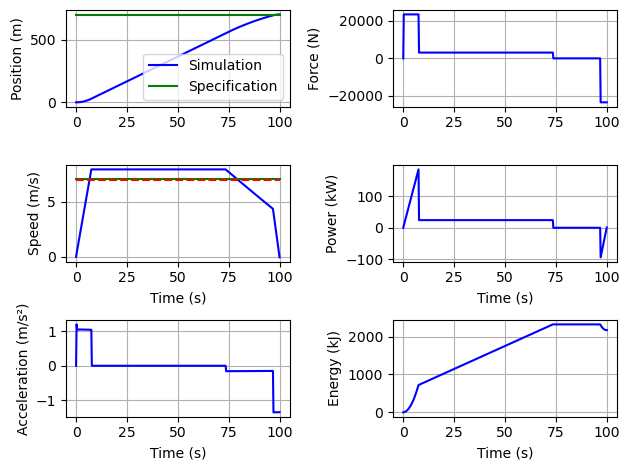

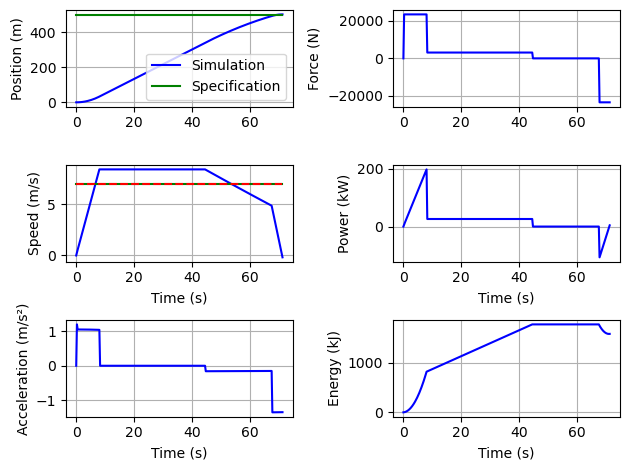

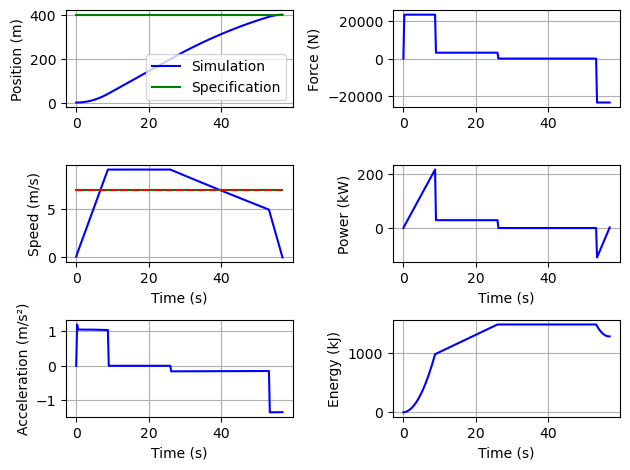

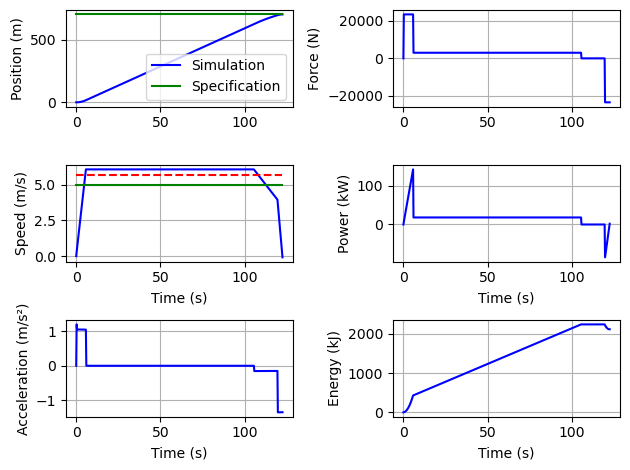

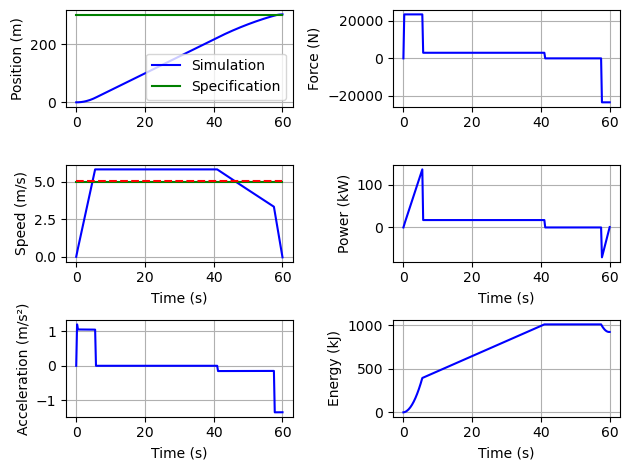

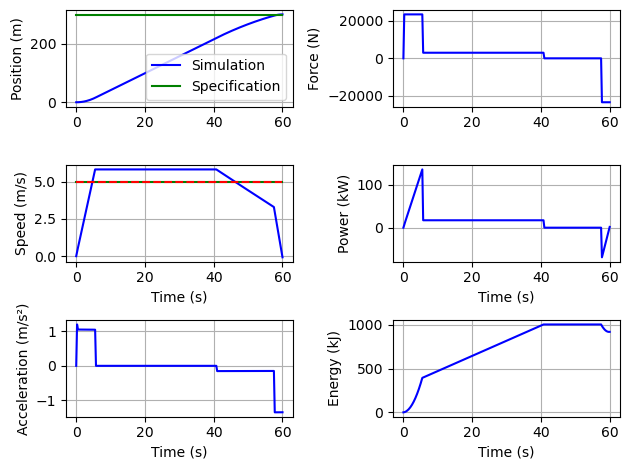

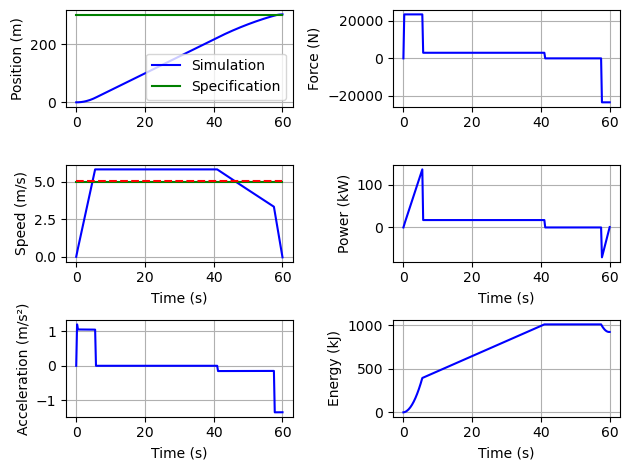

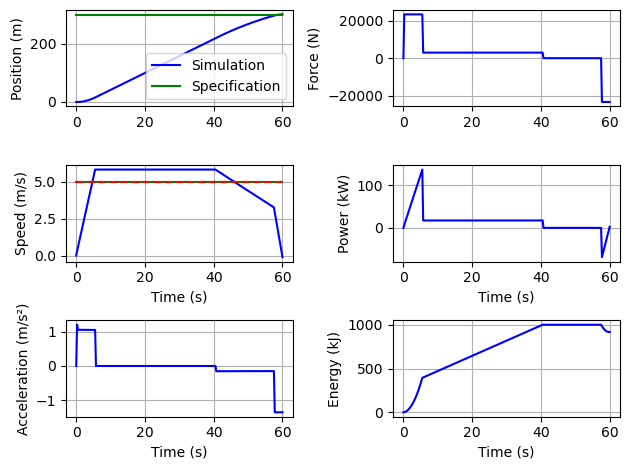

In [52]:
ToulouseC.optimLine()

In [53]:
ToulouseC.CalculPowerStorage()

0
1
2
3
4
5
6
7


In [74]:
omegaV=np.logspace(-5,2,50)
MassStorageV=[]
MassSC=[]
MassLFPAging=[]
MassLFPNRJ=[]
MassLFPPow=[]
CO2Total=[]

# Hypothese
Targetkm = 250e3 # [km] durée de vie du vehicule

# Energie massique des supercapacités
# https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf
# chez Skeleton
WmassSC=6.8*0.75 # [Wh/kg] on suppose pouvoir recuperer 75% de l'energie stockée
PmassSC=860/4.3*6.8*0.75 # [W/kg]

# Energie massique des batteries
# LFP
WmassLFP= 100 # [Wh/kg] les LFP peuvent pratiquement etre dechargé a 100%
PmassLFP=6*100 # [W/kg]  puissance massique en decharge à 6 C
PBmassLFP=1*100 # [W/kg]  puissance massique en decharge à 1 C
Ncycle = 3000 # [-] nb de cycle de decharge a 100%

# Bilan carbone
CO2SC = 39 # kgCO2eq/kg d'ecoInvent
CO2LFP = 11 # kgCO2eq/kg d'ecoInvent

for omega in omegaV:
    ToulouseC.FilterPower(omega)
    PmaxHF, PmaxLF, PmaxBrake, NRJHF, NRJLF, NRJLFAging = ToulouseC.IntegrateNRJ()
    MassStorageV = MassStorageV + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)
                                   +max(NRJLFAging*Targetkm/WmassLFP/Ncycle*1e3,NRJLF/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)] 
    MassSC = MassSC + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)] 
    MassLFPAging = MassLFPAging + [NRJLFAging*Targetkm/WmassLFP/Ncycle*1e3] 
    MassLFPNRJ = MassLFPNRJ + [NRJLF/WmassLFP*1e3] 
    MassLFPPow = MassLFPPow + [PmaxBrake/PBmassLFP*1e3]
    CO2Total = CO2Total + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)*CO2SC+
                           max(NRJLFAging*Targetkm/WmassLFP/Ncycle*1e3,NRJLF/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)*CO2LFP]


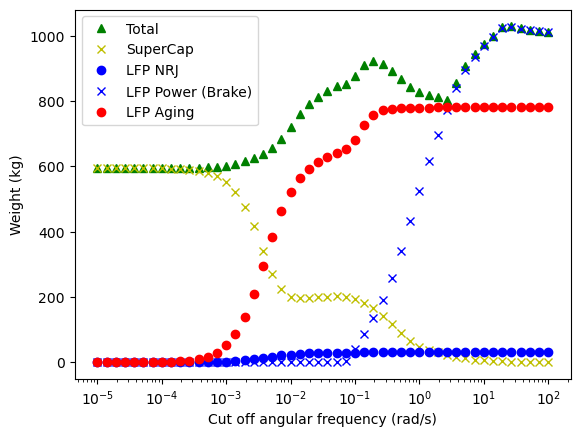

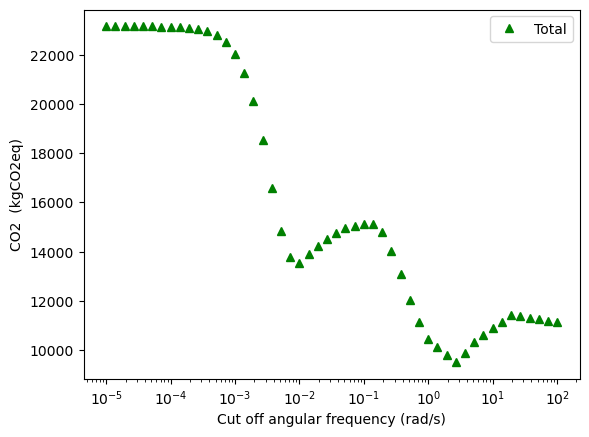

In [75]:

plt.plot(omegaV, MassStorageV, 'g^', label='Total')
plt.plot(omegaV, MassSC, 'yx', label='SuperCap')
plt.plot(omegaV, MassLFPNRJ, 'bo', label='LFP NRJ')
plt.plot(omegaV, MassLFPPow, 'bx', label='LFP Power (Brake)')
plt.plot(omegaV, MassLFPAging, 'ro', label='LFP Aging')
plt.xscale('log') 
plt.ylabel('Weight (kg)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()
plt.plot(omegaV, CO2Total, 'g^', label='Total')
plt.xscale('log') 
plt.ylabel('CO2  (kgCO2eq)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()

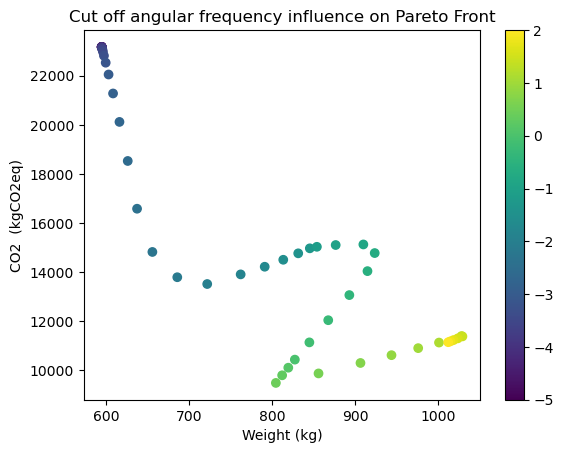

In [83]:
# Pareto Front

plt.scatter(MassStorageV, CO2Total, c=np.log10(omegaV))
plt.xlabel('Weight (kg)')
plt.ylabel('CO2  (kgCO2eq)')
plt.colorbar()
plt.title('Cut off angular frequency influence on Pareto Front')
plt.show()

In [70]:
omegaV

array([1.00000000e-05, 2.33572147e-05, 5.45559478e-05, 1.27427499e-04,
       2.97635144e-04, 6.95192796e-04, 1.62377674e-03, 3.79269019e-03,
       8.85866790e-03, 2.06913808e-02, 4.83293024e-02, 1.12883789e-01,
       2.63665090e-01, 6.15848211e-01, 1.43844989e+00, 3.35981829e+00,
       7.84759970e+00, 1.83298071e+01, 4.28133240e+01, 1.00000000e+02])

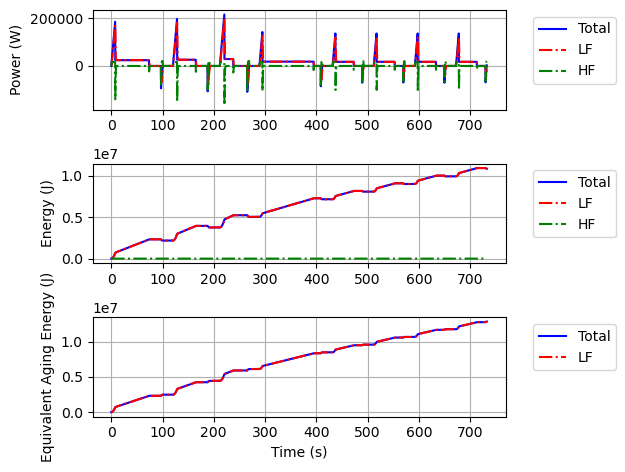

In [85]:
ToulouseC.FilterPower(3)
ToulouseC.plot()

In [ ]:
len(ToulouseC.PowerStorage)

### Energy storage system specification


> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE.

In [ ]:
omega=0.5
TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])

In [ ]:
Y = signal.lsim(TF, ToulouseC.PowerStorage , ToulouseC.GlobalTime)

In [ ]:
Y

In [ ]:
len(ToulouseC.GlobalTime)

In [ ]:
A=[700,500,400,700,300,300,300,300,300]

In [ ]:
sum(A)